In [273]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_error

## Importing Data

In [274]:
data = pd.read_csv("data_hw.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
data.shape
fts = list(data.columns)
fts.index("bedrooms")
fts

['area_type',
 'availability',
 'bedrooms',
 'total_sqft',
 'bath',
 'balcony',
 'ranked',
 'price in rupees']

## Handling Categorial Features

In [275]:
data['area_type'] = data['area_type'].replace(['B'],1)
data['area_type'] = data['area_type'].replace(['P'],0)
data.head()

,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,1,1,3.0,1655.0,3.0,1.0,134,10800000.0
1,1,1,2.0,1102.0,2.0,1.0,134,4800000.0
2,1,0,2.0,1112.0,2.0,1.0,242,8800000.0
3,1,1,3.0,1450.0,3.0,3.0,335,5100000.0
4,1,1,2.0,1010.0,2.0,1.0,261,4100000.0


## Train Validation Test Split

In [276]:
# x_train = data.iloc[0:500,:-1]
# y_train = data.iloc[0:500,-1]

x_train = data.iloc[0:8040,:-1]
y_train = data.iloc[0:8040,-1]

x_val = data.iloc[8041:10050, :-1]
y_val = data.iloc[8041:10050, -1]

x_test = data.iloc[10051:12563, :-1]
y_test = data.iloc[10051:12563, -1]

x_test.shape


(2512, 7)

## ---------------------------------------------------------------------------------------------------------------

# Regression Trees

## Regression Tree Algorithm

In [277]:
class RegressionTree():
    def __init__(self ,x, y,feature =None,threshold=None,
                 min_samples=None, max_depth=None, node_type=None, 
                 rule=None, depth=None):
        self.x = x
        self.y = y
        self.threshold = threshold
        self.feature = feature
        
        self.min_samples = min_samples if min_samples else 10
        self.max_depth = max_depth if max_depth else 4
        self.node_type = node_type if node_type else 'root'
        self.value = np.mean(y) 
        self.features = list(self.x.columns)
        self.depth = depth if depth else 0
        self.rule = rule if rule else ""
        self.left = None
        self.right= None
        
    
    def build_tree(self):
        df = self.x.copy()
        df["price in rupees"] = self.y
        curr_samples = len(self.y)
        best_split = {}
        if(self.max_depth > self.depth and curr_samples >= self.min_samples):
            
            best_split = self.best_split()
            best_ft = best_split['best_feature']
            best_score = best_split["best_score"]
            best_cut = best_split['best_cut']
            if(best_score is not None and len(best_split['left']) > 0 and len(best_split['right'])> 0):
                left_df = pd.DataFrame(best_split['left'], columns=data.columns)
                right_df = pd.DataFrame(best_split['right'], columns=data.columns)  
                
                left = RegressionTree(
                    left_df[self.features],
                    left_df["price in rupees"],
                    min_samples=self.min_samples,
                    max_depth=self.max_depth,
                    node_type='left_node',
                    depth=self.depth+1
                )
                self.left = left
                self.left.build_tree()

                right = RegressionTree(
                    right_df[self.features],
                    right_df["price in rupees"],
                    min_samples=self.min_samples,
                    max_depth=self.max_depth,
                    node_type='right_node',  
                    depth=self.depth+1   
                )
                self.right = right
                self.right.build_tree()

                self.feature = best_ft
                self.threshold = best_cut
                self.rule=f"{best_ft} <= {round(best_cut, 3)}"
            

    def inc_obs(self, length, mean, ssr, y):  #name stands for increase observation
        sum_prev = mean*(length-1)
        if (length == 0):
            return 0, 0, 0
        
        prev_mean = mean
        mean = (mean * (length - 1) + y) / (length)
        mean_sq = mean*mean
        prev_mean_sq = prev_mean*prev_mean
        prev_obs_ss = ssr - ((length-1)*prev_mean_sq) + (2*prev_mean*sum_prev)
        new_ssr = length*(mean_sq) -2*(mean*sum_prev) +prev_obs_ss -2*mean*y +(y*y)
        return length, mean, new_ssr

    
    def dec_obs(self, length, mean, ssr, y): #name stands for decrease observation
        sum_prev = mean*(length-1)
        prev_mean = mean
        prev_mean_sq = prev_mean*prev_mean
        if(length==0):
            return 0,0,0
        mean = (mean * (length + 1) - y) / (length)
        mean_sq = mean*mean
        prev_obs_ss = ssr - ((length+1)*prev_mean_sq) +(2*prev_mean*sum_prev)
        new_ssr = length*mean_sq -2*mean*(sum_prev-y) + (prev_obs_ss -(y*y))
        return length, mean, new_ssr
    
    def split(self, all_data, cut, feature):
        left = np.array([row for row in all_data if row[feature] <=cut])
        right = np.array([row for row in all_data if row[feature] >cut])
        return left,right
    
    
    def best_split(self):
        best_score = float('inf')
        best_split = {}
        all_data = self.y.values.reshape(-1,1)
        all_data = np.concatenate((np.array(self.x), all_data), axis=1)
        
        best_score = float('inf')
        for ft in range (len(self.features)): 
            thresholds = all_data[:,[ft,fts.index('price in rupees')]]
            thresholds = thresholds[thresholds[:,0].argsort()]
            
            mean1= np.mean(all_data[:,-1])
            len1 = len(thresholds)
            ssr1 = all_data[:,-1] - mean1
            ssr1*=ssr1
            ssr1 = sum(ssr1)
            mean2 =  0
            ssr2 = 0
            len2 = 0
            
            last_thresh = None
            for i in range(thresholds.shape[0]):
                score = ssr1+ssr2
                if score < best_score:
                    best_score = score
                    best_split['best_feature'] = self.features[ft]
                    best_split['best_feature_index'] = ft
                    if last_thresh != None:
                        best_split['best_cut'] = (thresholds[i][0] + last_thresh)/2
                    else:
                        best_split['best_cut'] =  thresholds[i][0]
                    best_split['best_score'] = score
                
                len2, mean2, ssr2 = self.inc_obs(len2+1,mean2,ssr2,thresholds[i][1])
                len1,mean1,ssr1 = self.dec_obs(len1-1,mean1,ssr1,thresholds[i][1])
                if last_thresh != thresholds[i][0]:
                    last_thresh = thresholds[i][0]
        left,right = self.split(all_data,best_split['best_cut'],best_split['best_feature_index'])
        best_split['left'] = left
        best_split['right'] = right
        return best_split
    
  
    def predict(self,x):
        return np.array([self.predict_row(row) for row in x.to_numpy()])
    
    def predict_row(self,row):
        if self.left == None and self.right==None:
            return self.value
        t = self.left if row[fts.index(self.feature)] <= self.threshold else self.right
        return t.predict_row(row)
    
 
    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const

        if self.node_type == 'root':
            print("Root")
        if self.left is not None and self.right is not None:
            print(f"|{spaces} Split rule: {self.rule}")
        else:
             print(f"|{spaces}")
      
        print(f"{' ' * const}   | Count of observations in node: {len(self.y)}")
        print(f"{' ' * const}   | Prediction of node: {self.value}")

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info()

        if self.left is not None:
            self.left.print_tree()

        if self.right is not None:
            self.right.print_tree()

            
        


## ---------------------------------------------------------------------------------------------------------------

# Training 

## Running Our Regression Tree and Fitting the Train Data

In [330]:
%%time
root = RegressionTree(x_train, y_train, max_depth=3, min_samples=10)
root.build_tree()

Wall time: 1.89 s


In [331]:
root.print_tree()

Root
| Split rule: total_sqft <= 2280.0
   | Count of observations in node: 8040
   | Prediction of node: 10685858.084577115
|-------- Split rule: bath <= 3.0
           | Count of observations in node: 7183
           | Prediction of node: 7974728.8041208405
|---------------- Split rule: total_sqft <= 1485.0
                   | Count of observations in node: 6577
                   | Prediction of node: 7294694.541584309
|------------------------
                           | Count of observations in node: 4951
                           | Prediction of node: 5962923.853766915
|------------------------
                           | Count of observations in node: 1626
                           | Prediction of node: 11349797.04797048
|---------------- Split rule: ranked <= 203.0
                   | Count of observations in node: 606
                   | Prediction of node: 15355232.673267327
|------------------------
                           | Count of observations in node: 358
     

## Running Sklearn's tree  

Wall time: 215 ms


[Text(2790.0, 4756.5, 'total_sqft <= 2277.5\nmse = 188332635796895.84\nsamples = 8040\nvalue = 10685858.085'),
 Text(1395.0, 3397.5, 'bath <= 2.5\nmse = 29561034321866.117\nsamples = 7180\nvalue = 7965999.582'),
 Text(697.5, 2038.5, 'total_sqft <= 1194.5\nmse = 11259851639747.195\nsamples = 4760\nvalue = 6025599.16'),
 Text(348.75, 679.5, 'mse = 3841926791929.636\nsamples = 2644\nvalue = 4802343.041'),
 Text(1046.25, 679.5, 'mse = 16322726863608.938\nsamples = 2116\nvalue = 7554091.21'),
 Text(2092.5, 2038.5, 'ranked <= 90.5\nmse = 43585703943343.125\nsamples = 2420\nvalue = 11782654.959'),
 Text(1743.75, 679.5, 'mse = 115170311259949.56\nsamples = 294\nvalue = 17927289.116'),
 Text(2441.25, 679.5, 'mse = 27743113462160.453\nsamples = 2126\nvalue = 10932926.623'),
 Text(4185.0, 3397.5, 'total_sqft <= 6350.0\nmse = 936491644026513.1\nsamples = 860\nvalue = 33393513.953'),
 Text(3487.5, 2038.5, 'ranked <= 51.5\nmse = 385790783331433.4\nsamples = 820\nvalue = 30380331.707'),
 Text(3138.75

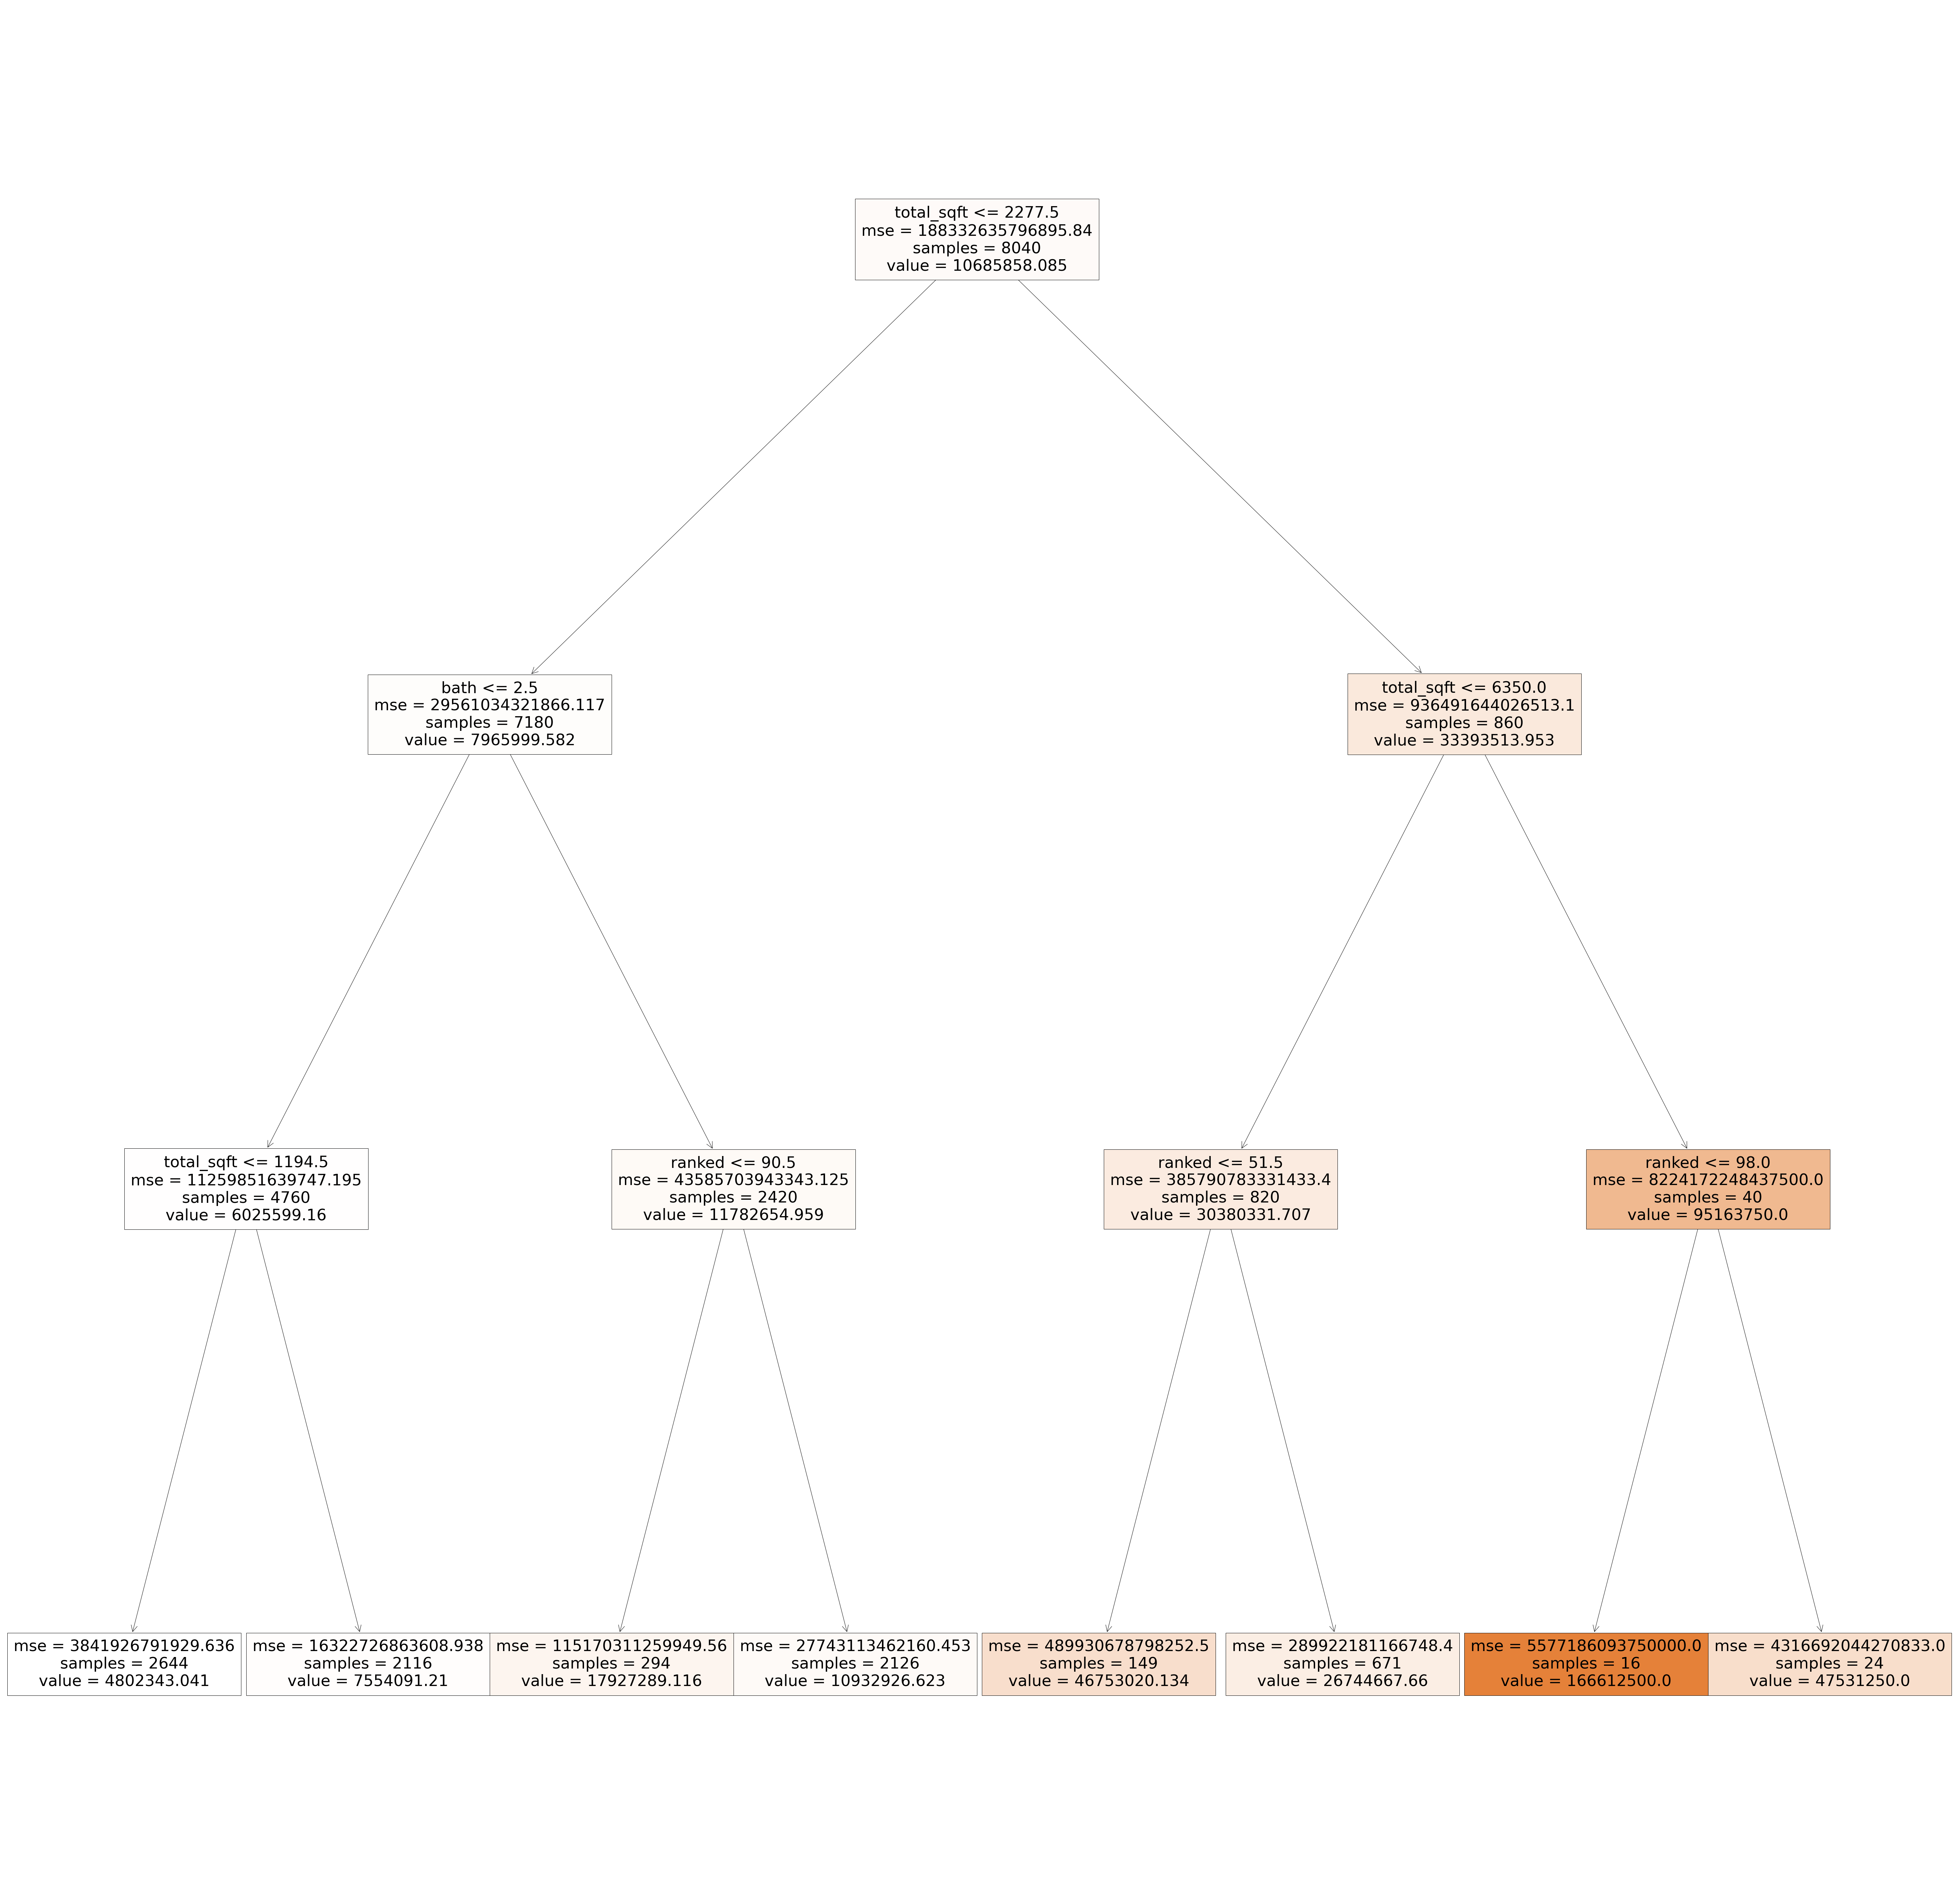

In [280]:
%%time
reg = DecisionTreeRegressor(random_state=0, max_depth=3, min_samples_split=10)
reg.fit(x_train , y_train)
# sklearn_pred = reg.predict(x_test)
fig = plt.figure(figsize=(100,100))
tree.plot_tree(reg, feature_names=x_train.columns, filled = True)

### Our training model took almost 1.3 seconds to run, while sklearn's took 240 ms
### Sklearn model has faster runtime

## ---------------------------------------------------------------------------------------------------------------

## Validation and Hypertuning

### Hypertuning according to our model 

In [281]:
%%time
grid_search = {"max_depth": [],  "min_samples": [], "mse_val": []}
max_mse=float('inf')
best_depth=0
best_split=0
for depth in range(1, 7):
    for samples in range(1,10):
        r = RegressionTree(x_train, y_train, max_depth=depth, min_samples = samples)
        r.build_tree()
        y_val_pred = r.predict(x_val)
        mse = round(mean_squared_error(y_val, y_val_pred), 3)
    
        grid_search["max_depth"].append(depth)
        grid_search["min_samples"].append(samples)
        grid_search["mse_val"].append(mse)

    print(f"Progress: Iteration {depth}/6")
    
        

Progress: Iteration 1/6
Progress: Iteration 2/6
Progress: Iteration 3/6
Progress: Iteration 4/6
Progress: Iteration 5/6
Progress: Iteration 6/6
Wall time: 1min 49s


In [282]:
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("mse_val").head()

,max_depth,min_samples,mse_val
39,5,4,4.870828e+13
36,5,1,4.870828e+13
37,5,2,4.870828e+13
38,5,3,4.870828e+13
40,5,5,4.870828e+13


In [283]:
i = grid_search.sort_values("mse_val").iloc[0]
best_max_depth = int(i['max_depth'])
best_min_samples = int(i['min_samples'])

In [284]:
best_max_depth , best_min_samples

(5, 4)

### Hypertuning according to our sklearn model


In [285]:
%%time
grid_search_sk = {"max_depth": [],  "min_samples": [], "mse_val": []}
max_mse=float('inf')
best_depth=0
best_split=0
for depth in range(2, 7):
    for samples in range(2,10):
        r = DecisionTreeRegressor(random_state=0, max_depth=depth, min_samples_split=samples)
        r.fit(x_train,y_train)
        y_val_pred = r.predict(x_val)
        mse = round(mean_squared_error(y_val, y_val_pred), 3)
    
        grid_search_sk["max_depth"].append(depth)
        grid_search_sk["min_samples"].append(samples)
        grid_search_sk["mse_val"].append(mse)

    print('Iteration ',depth)

Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Wall time: 522 ms


In [286]:
grid_search_sk = pd.DataFrame(grid_search)
grid_search_sk.sort_values("mse_val").head()

,max_depth,min_samples,mse_val
39,5,4,4.870828e+13
36,5,1,4.870828e+13
37,5,2,4.870828e+13
38,5,3,4.870828e+13
40,5,5,4.870828e+13


In [287]:
i = grid_search.sort_values("mse_val").iloc[0]
best_max_depth_sk = int(i['max_depth'])
best_min_samples_sk = int(i['min_samples'])
best_max_depth_sk , best_min_samples_sk

(5, 4)

### We got matching same hyper parameters values

## ---------------------------------------------------------------------------------------------------------------

# Testing

## Running our tree with optimized hyper parameters 

In [288]:
opt_root = RegressionTree(x_train, y_train, max_depth=best_max_depth, min_samples=best_min_samples)
opt_root.build_tree()

In [289]:
opt_root.print_tree()

Root
| Split rule: total_sqft <= 2280.0
   | Count of observations in node: 8040
   | Prediction of node: 10685858.084577115
|-------- Split rule: bath <= 3.0
           | Count of observations in node: 7183
           | Prediction of node: 7974728.8041208405
|---------------- Split rule: total_sqft <= 1485.0
                   | Count of observations in node: 6577
                   | Prediction of node: 7294694.541584309
|------------------------ Split rule: total_sqft <= 1195.0
                           | Count of observations in node: 4951
                           | Prediction of node: 5962923.853766915
|-------------------------------- Split rule: area_type <= 0.0
                                   | Count of observations in node: 2776
                                   | Prediction of node: 4971866.354466859
|----------------------------------------
                                           | Count of observations in node: 184
                                           | Pred

### Running Test Data and Calculating MSE for our Regression Tree 

In [290]:
y_predict = opt_root.predict(x_test)
mse_our_tree = round(mean_squared_error(y_test,y_predict),3)
mse_our_tree

75003126278526.02

## Running Test Data from Sklearn

In [291]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=best_max_depth, min_samples_split=best_min_samples)
regressor.fit(x_train , y_train)
sklearn_pred = regressor.predict(x_test)


[Text(2790.0, 4983.0, 'total_sqft <= 2277.5\nmse = 188332635796895.84\nsamples = 8040\nvalue = 10685858.085'),
 Text(1395.0, 4077.0, 'bath <= 2.5\nmse = 29561034321866.117\nsamples = 7180\nvalue = 7965999.582'),
 Text(697.5, 3171.0, 'total_sqft <= 1194.5\nmse = 11259851639747.195\nsamples = 4760\nvalue = 6025599.16'),
 Text(348.75, 2265.0, 'ranked <= 76.5\nmse = 3841926791929.636\nsamples = 2644\nvalue = 4802343.041'),
 Text(174.375, 1359.0, 'total_sqft <= 456.0\nmse = 11183143527636.07\nsamples = 84\nvalue = 8205321.429'),
 Text(87.1875, 453.0, 'mse = 643125000000.0\nsamples = 4\nvalue = 2675000.0'),
 Text(261.5625, 453.0, 'mse = 10104460561093.75\nsamples = 80\nvalue = 8481837.5'),
 Text(523.125, 1359.0, 'total_sqft <= 701.0\nmse = 3208597767360.84\nsamples = 2560\nvalue = 4690682.812'),
 Text(435.9375, 453.0, 'mse = 3121783336290.418\nsamples = 355\nvalue = 3190853.521'),
 Text(610.3125, 453.0, 'mse = 2802104908890.844\nsamples = 2205\nvalue = 4932151.927'),
 Text(1046.25, 2265.0, '

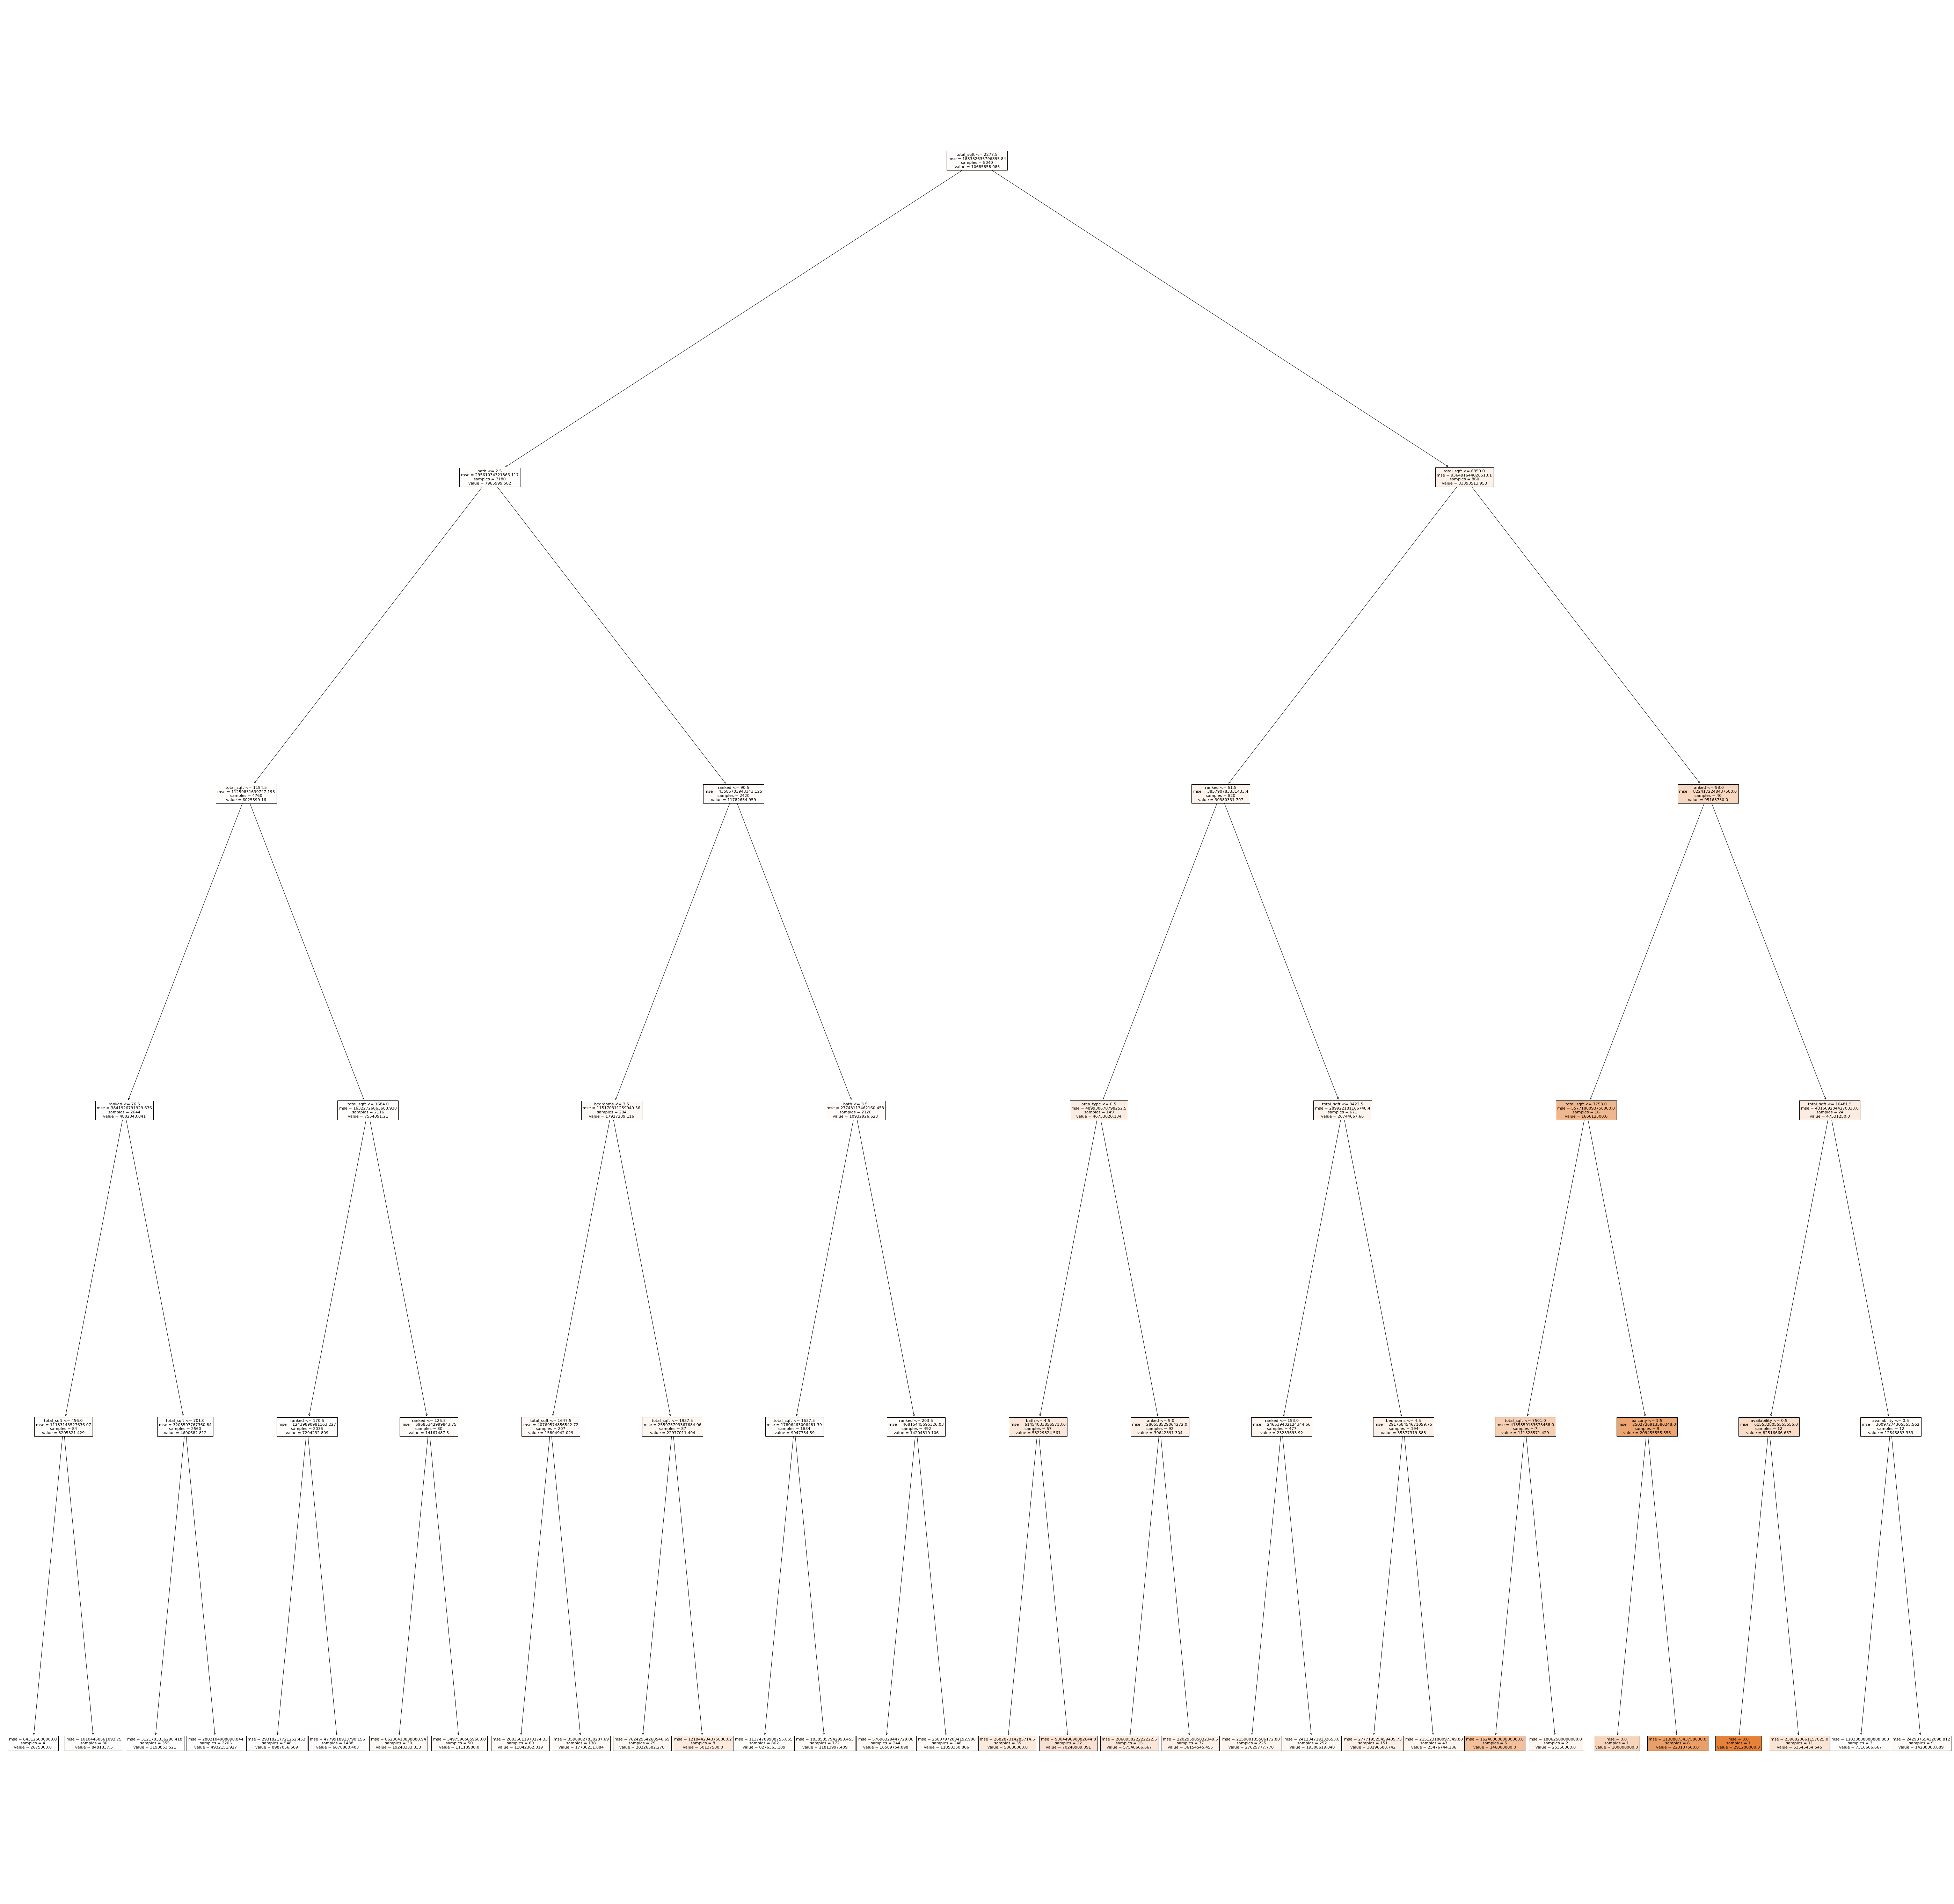

In [292]:
fig = plt.figure(figsize=(100,100))
tree.plot_tree(regressor, feature_names=x_train.columns, filled = True)

### MSE of Sklearn Model

In [293]:
mse_sklearn = round(mean_squared_error(y_test, sklearn_pred),3)

### Comparing MSEs 

In [25]:
print("MSE of our model: ",mse_our_tree)
print("MSE of sklearn model", mse_sklearn)
if mse_our_tree<mse_sklearn:  
    print('Our predictions are better') 
else: 
    print('Sklearn predictions are better')

MSE of our model:  75003126278526.02
MSE of sklearn model 66798115978726.625
Sklearn predictions are better


## ---------------------------------------------------------------------------------------------------------------


## Gradient Boost Regressor

In [260]:
def make_tree(x, residuals, max_depth=3, min_samples=5):  
    reg_tree = root = RegressionTree(x, residuals, max_depth=max_depth, min_samples=min_samples)                       
    reg_tree.build_tree()
    return reg_tree

In [261]:
def gradient_boost_regressor_fit(x_train,y_train,n_rounds=100,learning_rate=0.1,max_depth=3,min_samples=5):

    tress = []
    prev_pred = np.array([np.mean(y_train)])
    train = y_train
    new_pred=0
    
    for r in range(n_rounds):
        
        #Calculating residuals
        residuals = train - prev_pred
        
        #Building the regression tree to predict the residuals
        tree_grad = make_tree(x_train,residuals, max_depth=max_depth,min_samples=min_samples)
        
        #Predicting the residuals 
        predicted_res = tree_grad.predict(x_train)
             
        #making a new prediction
        new_pred += learning_rate * predicted_res
        prev_pred = new_pred
        
        tress.append(tree_grad)
        
    return tress


In [262]:
def gradient_boost_regressor_predict(test_x, trees, learning_rate, n_rounds):
    
    prev_pred = np.array([np.mean(y_train)])        
    new_pred = 0
    
    for i in range(n_rounds):
        
        tree = trees[i]
        update_pred = (tree.predict(test_x))
        new_pred += learning_rate * update_pred
    
    return new_pred

## Training 

In [263]:
%%time

learning_rate=0.1
n_rounds=100
max_depth = 3
min_samples = 5

trees_list = gradient_boost_regressor_fit(x_train, y_train, n_rounds, learning_rate)

Wall time: 2min 30s


### Testing data before optimization  

In [266]:
my_gb_predict = gradient_boost_regressor_predict(x_test, trees_list, learning_rate, n_rounds) 

In [267]:
print('MSE of our gb :',mean_squared_error(y_test,my_gb_predict))

MSE of test set : 38762159333625.734


### Training Sklearn model 

In [270]:
%%time
gb1 = GradientBoostingRegressor(random_state=0,learning_rate=0.1,n_estimators=100,min_samples_split=5,max_depth=3)
gb1.fit(x_train, y_train)


Wall time: 508 ms


GradientBoostingRegressor(min_samples_split=5, random_state=0)

### Testing data on sklearn model before optimization

In [271]:
sk_mse = mean_squared_error(y_test, gb.predict(x_test))
print ("Mean Squared Error:", sk_mse)

Mean Squared Error: 78363023613823.23


## Validation - Tuning hyper parameters

In [299]:
%%time
grid_search = {'learn_rate':[], 'n_estimators':[], 'mse_val': []}
l_rate = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
for l in range(len(l_rate)):
    print(l_rate[l])
    for n in range(100,300,50):
        t = gradient_boost_regressor_fit(x_train, y_train, n_rounds=n, learning_rate=l_rate[l])
        y_val_pred = my_gb_predict = gradient_boost_regressor_predict(x_val, t, learning_rate=l_rate[l], n_rounds=n) 
        est_mse = mean_squared_error(y_val, y_val_pred)
        grid_search['learn_rate'].append(l_rate[l])
        grid_search['n_estimators'].append(n)
        grid_search['mse_val'].append(est_mse)


0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
Wall time: 1h 42min 35s


In [300]:
grid_search = pd.DataFrame(grid_search)
grid_search.sort_values("mse_val").head()

,learn_rate,n_estimators,mse_val
35,0.5,250,4.131104e+13
33,0.5,150,4.131104e+13
32,0.5,100,4.131104e+13
34,0.5,200,4.131104e+13
27,0.4,250,4.401618e+13


In [304]:
i = grid_search.sort_values("mse_val").iloc[0]
best_n_estimators = int(i['n_estimators'])
best_n_estimators
best_learning_rate = i['learn_rate']
best_learning_rate, best_n_estimators

(0.5, 250)

In [306]:
grid_search.sort_values("mse_val").head()

,learn_rate,n_estimators,mse_val
35,0.5,250,4.131104e+13
33,0.5,150,4.131104e+13
32,0.5,100,4.131104e+13
34,0.5,200,4.131104e+13
27,0.4,250,4.401618e+13


## Testing  our model with tuned hyper parameters 

In [316]:
%%time
trees_opt = gradient_boost_regressor_fit(x_train,y_train,n_rounds=best_n_estimators, learning_rate=best_learning_rate)


Wall time: 6min 22s


In [324]:
%%time
y_pred_mine= gradient_boost_regressor_predict(x_test,trees_opt,n_rounds=best_n_estimators,learning_rate=best_learning_rate)
opt_mse = mean_squared_error(y_test, y_pred_mine)
print ("Mean Squared Error - our optimized model:", opt_mse)

Mean Squared Error - our optimized model: 44972791921566.266
Wall time: 1.42 s


## Testing Sklearn model with tuned hyper parameters 

In [323]:
%%time
gb1 = GradientBoostingRegressor(random_state=0,n_estimators=best_n_estimators,learning_rate=best_learning_rate, min_samples_split=3,max_depth=10)
gb1.fit(x_train, y_train)
GradientBoostingRegressor(random_state=0)
opt_sk_mse = mean_squared_error(y_test, gb1.predict(x_test))
print ("Mean Squared Error - sklearn model", sk1_mse)

Mean Squared Error - sklearn model 60148448406167.74
Wall time: 4.42 s


### Comparison

In [327]:
print("MSE of our model: ",opt_mse)
print("MSE of sklearn model", opt_sk_mse)
if opt_mse < opt_sk_mse:
    print('Our predictions are better') 
else:
    print('Sklearn predictions are better')

MSE of our model:  44972791921566.266
MSE of sklearn model 60148448406167.74
Our predictions are better
